In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from typing import Optional, List, Union, Tuple, Callable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from PIL import Image
import time
from torch.nn import DataParallel
import torch.optim as optim

In [2]:
! python --version

Python 3.7.7


# Semi-Supervised Learning Tutorial with Auxiliary Rotation-Loss

### Import ResNet Modules

In [3]:
from resnet import ResNet, BasicBlock, Bottleneck

### Define Semi-Supervised ResNet

In [4]:
class SemiResNet(ResNet):
    def __init__(self, block: Union[BasicBlock, Bottleneck], num_blocks: List[int], num_classes: int=10, 
                        zero_init_residual: bool=False, rotation_types: Optional[int]=None):
        super(SemiResNet, self).__init__(block, num_blocks, num_classes, 
                                         zero_init_residual=zero_init_residual)

        if rotation_types is not None:
            self.unlab_linear = nn.Linear(512 * block.expansion, rotation_types)

    def forward(self, x: torch.Tensor, unlabel: Optional[bool] = False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out_lab = self.linear(out)

        if hasattr(self, 'unlab_linear'):
            if unlabel:
                out_unlab = self.unlab_linear(out)
                return out_lab, out_unlab

        elif not hasattr(self, 'unlab_linear'):
            if unlabel:
                raise NotImplementedError('self.unlab_linear is not enabled.')
        # else:
        #     raise NotImplementedError('self.unlab_linear is not enabled')
        return out_lab

In [5]:
def SemiResNet18(num_classes: int, rotation_types: Optional[int]=None):
    return SemiResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, rotation_types=rotation_types)


def SemiResNet34(num_classes: int, rotation_types: Optional[int]=None):
    return SemiResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, rotation_types=rotation_types)


def SemiResNet50(num_classes: int, rotation_types: Optional[int]=None):
    return SemiResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, rotation_types=rotation_types)


def SemiResNet101(num_classes: int, rotation_types: Optional[int]=None):
    return SemiResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, rotation_types=rotation_types)


def SemiResNet152(num_classes: int, rotation_types: Optional[int]=None):
    return SemiResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, rotation_types=rotation_types)

### Define Random Rotation Class

It takes an image and returns a rotated version of the actual images

In [6]:
class SemiTransform(object):

    def __init__(self) -> None:

        self.classes = ['0', '90', '180', '270', 'hflip', 'vflip']

    def __call__(self, x: torch.Tensor) -> Tuple[torch.Tensor, int]:

        rotation_type = int(np.random.randint(low=0, high=int(len(self.classes)), size=(1,))[0])

        if rotation_type == 0:
            pass
        elif rotation_type == 1:
            x = transforms.functional.rotate(x, 90)
        elif rotation_type == 2:
            x = transforms.functional.rotate(x, 180)
        elif rotation_type == 3:
            x = transforms.functional.rotate(x, 270)
        elif rotation_type == 4:
            x = transforms.functional.hflip(x)
        elif rotation_type == 5:
            x = transforms.functional.rotate(x, 180)
            x = transforms.functional.hflip(x)
        else:
            raise ValueError('Unknown rotation type: {}'.format(rotation_type))
        
        return x, rotation_type

### Define Custom Cifar10 dataset

In [7]:
class CIFAR10(datasets.CIFAR10):

    def __init__(self, root: str, train: bool = True, transform: Optional[Callable] = None, 
                 target_transform: Optional[Callable] = None, download: bool = True, 
                 required_rotation: bool=False) -> None:
        
        super(CIFAR10, self).__init__(root=root, train=train, transform=transform, 
                                      target_transform=target_transform, download=download)

        self.required_rotation = required_rotation
        
        if self.required_rotation:
            self.ssl_transform = SemiTransform()

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], 
                                               Tuple[torch.Tensor, int, torch.Tensor, int]]:
        
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.

            or,

            tuple: (image, target, rotated_image, rotation_type) where target is index of the target class, 
                    and rotation_type is the type of rotation that has been applied.
        """
        img, target = self.data[index], self.targets[index]
        
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if self.required_rotation:
            r_img, rotation_type = self.ssl_transform(img)
            
            return img, target, r_img, rotation_type

        return img, target

### Define train and test transformation

In [8]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
dataset = datasets.CIFAR10(root='../data', train=True, download=True)

print('# dataset: {}'.format(len(dataset)))

Files already downloaded and verified
# dataset: 50000


### Separate train-set into validation-set, labeled-train-set & unlabeled-train-set

In [10]:
num_val = 5000
num_label_train = 2500
num_unlabel_train = 42500

In [11]:
all_indices = np.arange(len(dataset))
np.random.shuffle(all_indices)
print('len(all_indices): {}'.format(len(all_indices)))

val_indices = all_indices[:num_val]
all_indices = all_indices[num_val:]
print('len(val_indices): {}'.format(len(val_indices)))
print('len(all_indices): {}'.format(len(all_indices)))

label_train_indices = all_indices[:num_label_train]
all_indices = all_indices[num_label_train:]
print('len(label_train_indices): {}'.format(len(label_train_indices)))
print('len(all_indices): {}'.format(len(all_indices)))

len(all_indices): 50000
len(val_indices): 5000
len(all_indices): 45000
len(label_train_indices): 2500
len(all_indices): 42500


In [12]:
train_dataset = CIFAR10(root='../data', train=True, download=True, 
                        transform=train_transform, required_rotation=True) # this calls our custom cifar10
                                                                           # class

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.CIFAR10(root='../data', train=True, 
                               download=True, transform=test_transform) # this calls torchvision cifar10 class

Files already downloaded and verified
Files already downloaded and verified


In [13]:
label_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                                sampler=SubsetRandomSampler(list(label_train_indices)),
                                                num_workers=4, pin_memory=True)

unlabel_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                                sampler=SubsetRandomSampler(list(all_indices)),
                                                num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                                sampler=SubsetRandomSampler(list(val_indices)),
                                                num_workers=4, pin_memory=True)

### Define test-set

In [14]:
test_dataset = datasets.CIFAR10(root='../data', train=True, download=True,
                               transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=128,
                                         num_workers=4, pin_memory=True)

Files already downloaded and verified


## CNN (fully-supervised) Training

In [15]:
def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target, _, _) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} \
              val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

## CNN (semi-supervised with auxiliary rotation-loss) Training

In [16]:
def trainClsSSL(model: nn.Module, label_train_loader: torch.utils.data.DataLoader, 
             unlabel_train_loader: torch.utils.data.DataLoader,   
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        rotation_loss, u_count = 0.0, 0
        
        for _, (data, target, _,_) in enumerate(label_train_loader): # getting a batch of labeled data
            data, target = data.to(device), target.to(device)
            
#             l_img, l_target = l_img.to(device), l_target.to(device)
            
            _, _, r_img, r_target = next(iter(unlabel_train_loader)) # getting a batch of unlabeled data
            r_img, r_target = r_img.to(device), r_target.to(device)
            
#             r_img = torch.cat((l_img, r_img), dim=0)
#             r_target = torch.cat((l_target, r_target), dim=0)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            label_loss = criterion(output, target)
            
            _, r_output = model(r_img, True)
            unlabel_loss = criterion(r_output, r_target)
            
            loss = label_loss + unlabel_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss += label_loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
            
            rotation_loss += unlabel_loss.item() * r_img.size(0)
            u_count += r_img.size(0)
        
        train_loss, train_acc = train_loss/len(label_train_loader.sampler), \
                                            train_acc/len(label_train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)
        
        rotation_loss /= u_count

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} \
              val_loss: {:0.4f} rotation_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, 
                                                          train_loss, val_loss, rotation_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

### Semi-ResNet-34 training and testing

In [17]:
model_semi_resnet = SemiResNet34(num_classes=10, rotation_types=6)

print(model_semi_resnet)

SemiResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [18]:
# testing with random data

t = torch.randn(10, 3, 32, 32)

with torch.no_grad():
    out = model_semi_resnet(t)
    print(t.shape, out.shape)
    out1, out2 = model_semi_resnet(t, True)
    print(t.shape, out1.shape, out2.shape)

torch.Size([10, 3, 32, 32]) torch.Size([10, 10])
torch.Size([10, 3, 32, 32]) torch.Size([10, 10]) torch.Size([10, 6])


In [19]:
model_semi_resnet, train_loss, val_loss, train_acc, val_acc = trainClsSSL(model_semi_resnet, 
                                        label_train_loader, unlabel_train_loader, val_loader, 
                                        lr=0.002, epochs=100, momentum=0.9, weight_decay=5e-4, 
                                        checkpoint='semi_resnet_34_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.1154
Epoch: [1/100] train_acc: 0.1184 val_acc: 0.1154 train_loss: 2.3169               val_loss: 2.2746 rotation_loss: 1.8283
Epoch: 2 val accuracy improved: 0.1154 ==> 0.1696
Epoch: [2/100] train_acc: 0.1512 val_acc: 0.1696 train_loss: 2.2410               val_loss: 2.1854 rotation_loss: 1.7899
Epoch: 3 val accuracy improved: 0.1696 ==> 0.2198
Epoch: [3/100] train_acc: 0.1760 val_acc: 0.2198 train_loss: 2.1610               val_loss: 2.1120 rotation_loss: 1.7555
Epoch: 4 val accuracy improved: 0.2198 ==> 0.2208
Epoch: [4/100] train_acc: 0.2184 val_acc: 0.2208 train_loss: 2.0557               val_loss: 2.0439 rotation_loss: 1.7412
Epoch: 5 val accuracy improved: 0.2208 ==> 0.2664
Epoch: [5/100] train_acc: 0.2312 val_acc: 0.2664 train_loss: 2.0023               val_loss: 1.9452 rotation_loss: 1.7237
Epoch: [6/100] train_acc: 0.2636 val_acc: 0.2454 train_loss: 1.9466               val_loss: 2.0317 rotation_loss: 1.7070
Epoch: 7 

Epoch: [59/100] train_acc: 0.5520 val_acc: 0.4540 train_loss: 1.2354               val_loss: 1.5373 rotation_loss: 1.5242
Epoch: 60 val accuracy improved: 0.4786 ==> 0.4792
Epoch: [60/100] train_acc: 0.5608 val_acc: 0.4792 train_loss: 1.2437               val_loss: 1.4781 rotation_loss: 1.5362
Epoch: [61/100] train_acc: 0.5636 val_acc: 0.4664 train_loss: 1.2649               val_loss: 1.5757 rotation_loss: 1.5474
Epoch: [62/100] train_acc: 0.5604 val_acc: 0.4606 train_loss: 1.2380               val_loss: 1.6212 rotation_loss: 1.5524
Epoch: [63/100] train_acc: 0.5664 val_acc: 0.4736 train_loss: 1.2311               val_loss: 1.5266 rotation_loss: 1.5459
Epoch: 64 val accuracy improved: 0.4792 ==> 0.4808
Epoch: [64/100] train_acc: 0.5712 val_acc: 0.4808 train_loss: 1.2100               val_loss: 1.5331 rotation_loss: 1.5312
Epoch: [65/100] train_acc: 0.5804 val_acc: 0.4506 train_loss: 1.1884               val_loss: 1.6050 rotation_loss: 1.5307
Epoch: 66 val accuracy improved: 0.4808 ==> 

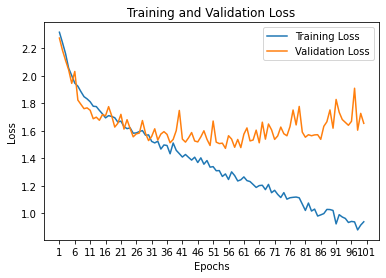

In [20]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()


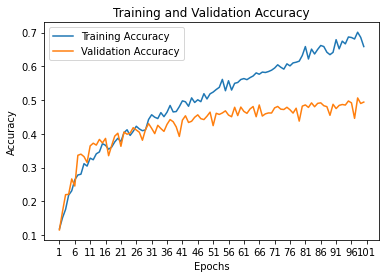

In [21]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model_semi_resnet.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model_semi_resnet, DataParallel):
        model_semi_resnet = DataParallel(model_semi_resnet) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model_semi_resnet.to(device) # load model to device

device: cuda:0


SemiResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [23]:
checkpoint = 'semi_resnet_34_best_model.pth'

try:
    model_semi_resnet.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model_semi_resnet.module.load_state_dict(torch.load(checkpoint, map_location=device))


In [24]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model_semi_resnet.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model_semi_resnet
    output = model_semi_resnet(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() \
                    else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(128, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.5480

Test Accuracy of airplane: 57% (2898/5000)
Test Accuracy of automobile: 77% (3864/5000)
Test Accuracy of  bird: 38% (1926/5000)
Test Accuracy of   cat: 28% (1404/5000)
Test Accuracy of  deer: 46% (2346/5000)
Test Accuracy of   dog: 38% (1917/5000)
Test Accuracy of  frog: 53% (2650/5000)
Test Accuracy of horse: 65% (3295/5000)
Test Accuracy of  ship: 63% (3174/5000)
Test Accuracy of truck: 54% (2725/5000)

Test Accuracy (Overall): 52% (26199/50000)


### ResNet-34 training and testing

In [26]:
from resnet import ResNet34

model_resnet = ResNet34(num_classes=10)

print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [27]:
# testing with random data

t = torch.randn(10, 3, 32, 32)

with torch.no_grad():
    out = model_resnet(t)
    print(t.shape, out.shape)

torch.Size([10, 3, 32, 32]) torch.Size([10, 10])


In [28]:
model_resnet, train_loss, val_loss, train_acc, val_acc = trainCls(model_resnet, 
                                        label_train_loader, val_loader, 
                                        lr=0.002, epochs=100, momentum=0.9, weight_decay=5e-4, 
                                        checkpoint='resnet_34_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.0960
Epoch: [1/100] train_acc: 0.1176 val_acc: 0.0960 train_loss: 2.3488               val_loss: 2.3367
Epoch: 2 val accuracy improved: 0.0960 ==> 0.1638
Epoch: [2/100] train_acc: 0.1512 val_acc: 0.1638 train_loss: 2.2697               val_loss: 2.2604
Epoch: 3 val accuracy improved: 0.1638 ==> 0.1858
Epoch: [3/100] train_acc: 0.1928 val_acc: 0.1858 train_loss: 2.1749               val_loss: 2.1766
Epoch: 4 val accuracy improved: 0.1858 ==> 0.2194
Epoch: [4/100] train_acc: 0.2260 val_acc: 0.2194 train_loss: 2.0484               val_loss: 2.0671
Epoch: 5 val accuracy improved: 0.2194 ==> 0.2654
Epoch: [5/100] train_acc: 0.2308 val_acc: 0.2654 train_loss: 1.9807               val_loss: 1.9384
Epoch: 6 val accuracy improved: 0.2654 ==> 0.2984
Epoch: [6/100] train_acc: 0.2720 val_acc: 0.2984 train_loss: 1.9411               val_loss: 1.8446
Epoch: 7 val accuracy improved: 0.2984 ==> 0.3088
Epoch: [7/100] train_acc: 0.2832 val_acc:

Epoch: [71/100] train_acc: 0.5988 val_acc: 0.4580 train_loss: 1.1348               val_loss: 1.5954
Epoch: [72/100] train_acc: 0.5956 val_acc: 0.4738 train_loss: 1.1388               val_loss: 1.5912
Epoch: [73/100] train_acc: 0.6228 val_acc: 0.4604 train_loss: 1.0880               val_loss: 1.6185
Epoch: [74/100] train_acc: 0.6360 val_acc: 0.4596 train_loss: 1.0603               val_loss: 1.7547
Epoch: [75/100] train_acc: 0.6176 val_acc: 0.4656 train_loss: 1.0825               val_loss: 1.7016
Epoch: [76/100] train_acc: 0.6108 val_acc: 0.4590 train_loss: 1.1012               val_loss: 1.6792
Epoch: [77/100] train_acc: 0.6192 val_acc: 0.4672 train_loss: 1.1059               val_loss: 1.6480
Epoch: 78 val accuracy improved: 0.4878 ==> 0.4902
Epoch: [78/100] train_acc: 0.6216 val_acc: 0.4902 train_loss: 1.0862               val_loss: 1.5804
Epoch: [79/100] train_acc: 0.6264 val_acc: 0.4552 train_loss: 1.0690               val_loss: 1.8348
Epoch: [80/100] train_acc: 0.6380 val_acc: 0.4798

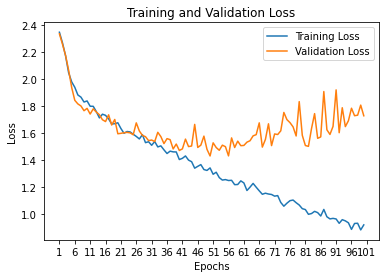

In [29]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()


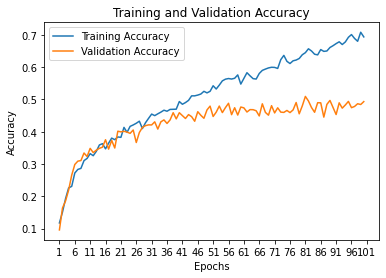

In [30]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model_resnet.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model_resnet, DataParallel):
        model_semi_resnet = DataParallel(model_resnet) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model_resnet.to(device) # load model to device

device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [32]:
checkpoint = 'resnet_34_best_model.pth'

try:
    model_resnet.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model_resnet.module.load_state_dict(torch.load(checkpoint, map_location=device))


In [33]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [34]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model_resnet.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model_resnet
    output = model_resnet(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() \
                    else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(128, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.4836

Test Accuracy of airplane: 65% (3266/5000)
Test Accuracy of automobile: 61% (3087/5000)
Test Accuracy of  bird: 27% (1389/5000)
Test Accuracy of   cat: 35% (1753/5000)
Test Accuracy of  deer: 34% (1723/5000)
Test Accuracy of   dog: 46% (2304/5000)
Test Accuracy of  frog: 63% (3177/5000)
Test Accuracy of horse: 58% (2944/5000)
Test Accuracy of  ship: 60% (3017/5000)
Test Accuracy of truck: 66% (3310/5000)

Test Accuracy (Overall): 51% (25970/50000)
